# Multi-agent network

A single agent can usually operate effectively using a handful of tools within a single domain, but even using powerful models like `gpt-4`, it can be less effective at using many tools. 

One way to approach complicated tasks is through a "divide-and-conquer" approach: create an specialized agent for each task or domain and route tasks to the correct "expert". This is an example of a [multi-agent network](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#network) architecture.

This notebook (inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al.) shows one way to do this using LangGraph.

The resulting graph will look something like the following diagram:

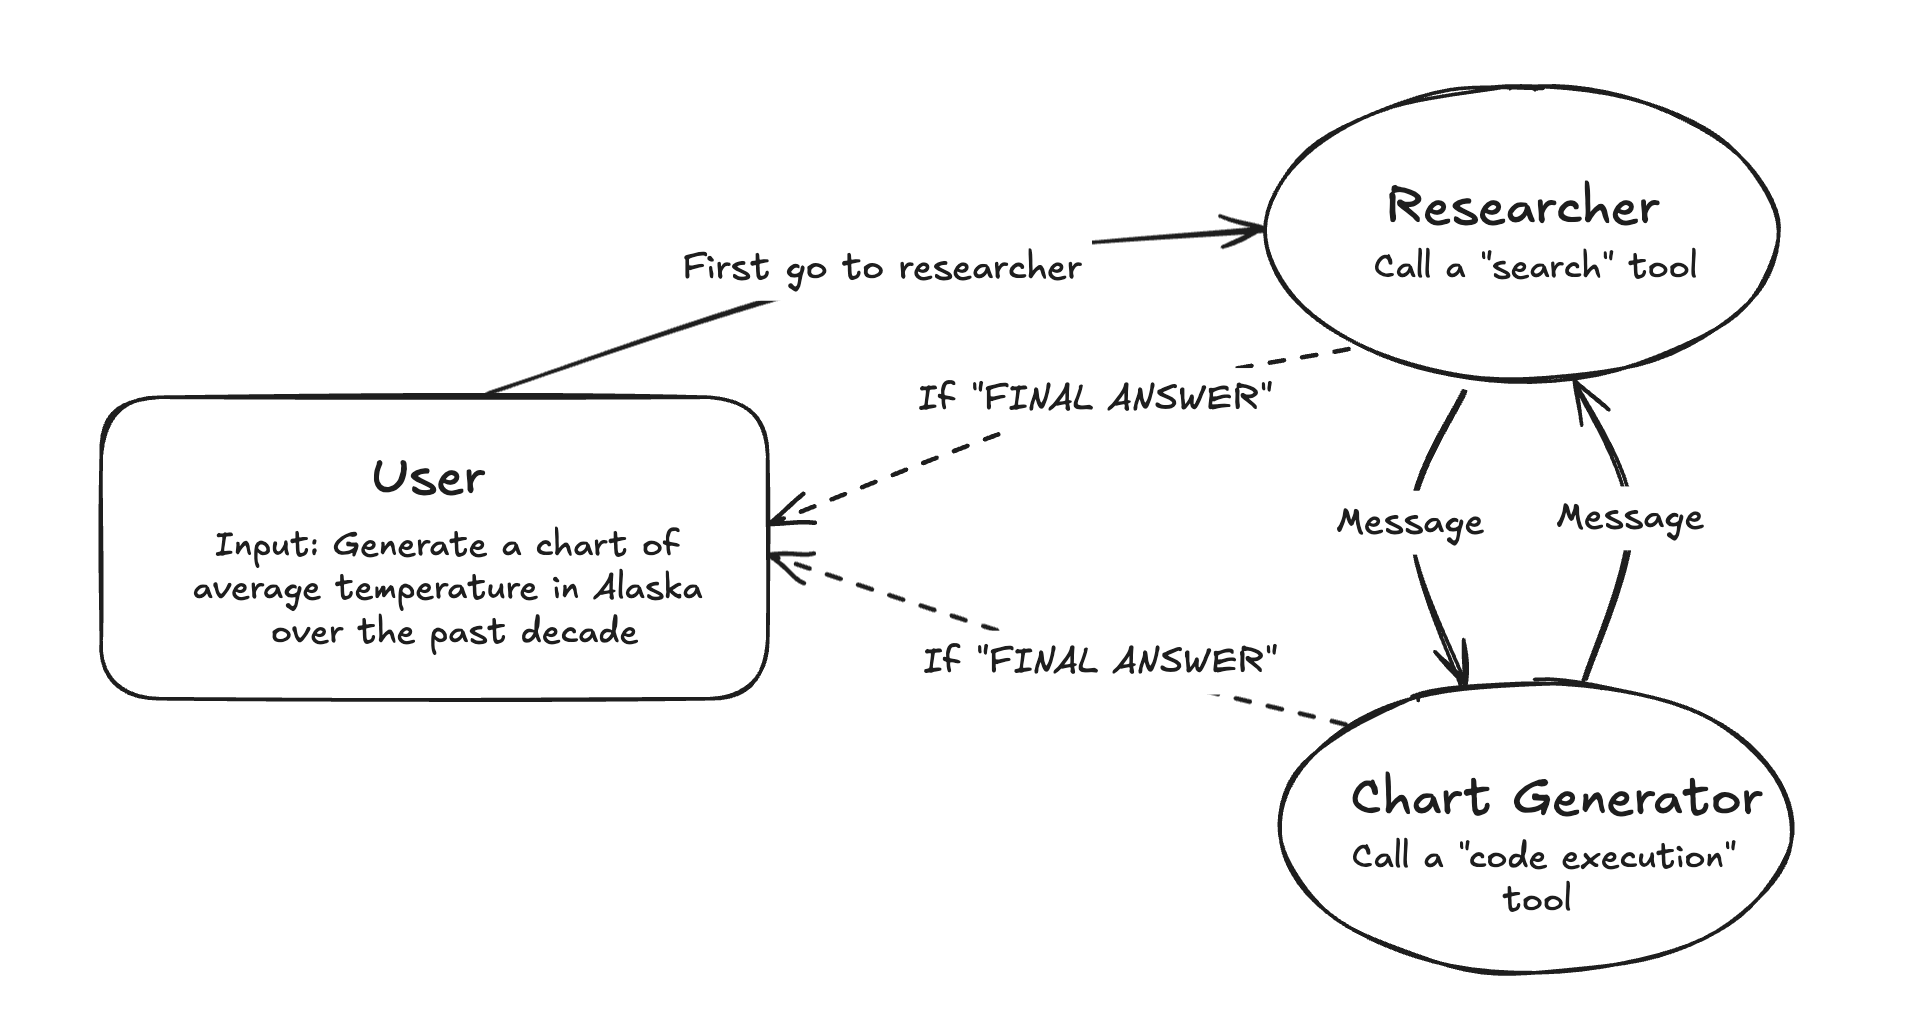

Before we get started, a quick note: this and other multi-agent notebooks are designed to show _how_ you can implement certain design patterns in LangGraph. If the pattern suits your needs, we recommend combining it with some of the other fundamental patterns described elsewhere in the docs for best performance.

## Setup

First, let's install our required packages and set our API keys:

In [1]:
%%capture --no-stderr
%pip install -U langchain_community langchain_anthropic langchain_experimental matplotlib langgraph

In [ ]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("ANTHROPIC_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

In [1]:
import configparser
config = configparser.ConfigParser()
config.read("config.properties")

APIKey = config.get("AzureCredentials","APIKey").strip()
Endpoint = config.get("AzureCredentials","Endpoint").strip()
Deployment = config.get("AzureCredentials","Deployment").strip()
version = config.get("AzureCredentials","version").strip()

Googlekey = config.get('GoogleCred','key')


In [34]:
from langchain_aws import ChatBedrock
import boto3
import requests
# boto3.setup_default_session(
#     **requests.get("http://localhost:8000/awscred").json()    
# )

client = ""
llm = ""
def renew():
  global llm
  global client
  boto3.setup_default_session(
      **requests.get("http://localhost:8000/awscred").json()
  )
  client = boto3.client(service_name="bedrock-runtime",region_name="us-east-1")
  llm = ChatBedrock(model_id ="anthropic.claude-3-5-sonnet-20240620-v1:0",
                  client = client,
                  model_kwargs={"max_tokens":5000}
                  #   guardrails={"id": "xpqvrjzg8jpl", "version": "5"}
                  )
renew()
print(llm.invoke("HI , i am facing issue i this azure"))


content="Hello! I'm here to help you with your Azure issue. To assist you better, could you please provide more details about the specific problem you're facing? It would be helpful if you could include information such as:\n\n1. What Azure service or resource are you working with?\n2. What specific task were you trying to accomplish?\n3. What error message or unexpected behavior are you encountering?\n4. Any relevant code snippets or configuration details, if applicable.\n\nThe more information you can provide, the better I'll be able to assist you in resolving your Azure issue." additional_kwargs={'usage': {'prompt_tokens': 17, 'completion_tokens': 125, 'total_tokens': 142}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'} response_metadata={'usage': {'prompt_tokens': 17, 'completion_tokens': 125, 'total_tokens': 142}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'} id='run-4df13008-7f75-4bf7-bb09-f752f90d2535-0' 

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Define tools

We will also define some tools that our agents will use in the future

In [35]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user. if there is a graph then plot properly"""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

## Create graph

Now that we've defined our tools and made some helper functions, will create the individual agents below and tell them how to talk to each other using LangGraph.

### Define Agent Nodes

We now need to define the nodes.

First, we'll create a utility to create a system prompt for each agent.

In [36]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [37]:
from langchain_core.tools import tool
from langchain_community.document_transformers import Html2TextTransformer
from langchain_community.document_loaders import AsyncHtmlLoader
from langchain_community.utilities import GoogleSearchAPIWrapper
from duckduckgo_search import DDGS
import os

os.environ["GOOGLE_CSE_ID"] = config.get('GoogleCred','GOOGLE_CSE_ID')
os.environ["GOOGLE_API_KEY"] = config.get('GoogleCred','GOOGLE_API_KEY')

html2text = Html2TextTransformer()
from langchain_core.tools import Tool

def scrapeFromURLs(URLs):
    if isinstance(URLs,str):
        URLs = [URLs]
    loader = AsyncHtmlLoader(URLs,ignore_load_errors=True)
    docs = loader.load() 
    docs_transformed = html2text.transform_documents(docs)
    return docs_transformed


search = GoogleSearchAPIWrapper()
def TopGoogleResult(query):
    return search.results(query, 10)

# ______________________________________________________ DuckDuckGO
def top5_it_results(query):
    results = DDGS().text(query, max_results=10)
    return results

Gtool = Tool(
        name="Google Search Snippets",
        description="Search Google for problem's solution.",
        func=TopGoogleResult,
    )

def refactor(Docs):
    try:
        if isinstance(Docs,str):
            Docs = [Docs]
        _refactorList = []
        for doc in Docs:
            WebTemplate = f"""You are Advance refactor for web scrapped text and you give the most relevant information from the messy document ,here is the new web Ducument:'{doc}' , please provide only the relevant answer within 80 words for user question only ,response:"""
            _refactorList.append(llm.invoke(WebTemplate).content.replace('{','}').replace('}','{'))
        return _refactorList
    except Exception as e:
        print("Azure interuption.....")
        return [f"The website contains in appropriate data so it was filtered,guradrail interuption "]


def search_web(search_query):
    '''A websearch tool which search into web and accepts a web search query'''
    try:
        webpages_to_include = 3

        # structured_llm = llm.with_structured_output(SearchQuery)
        # search_query = structured_llm.invoke([search_instructions]+state['messages']).search_query
        
        Gresult = Gtool.run(search_query)
        Dtool = Tool(
            name="Google Search Snippets",
            description="Search Google for problem's solution.",
            func=top5_it_results,
        )
        # Dresult = Dtool.run(user_text) 

        allResult = Gresult #+ Dresult 
        web_URL = [website.get("link",website.get("href")) for website in allResult]
        web_URL =list(set(web_URL))
        idx = 0 
        document_list = []
        for _, URL in enumerate(web_URL):
            try:
                # WebPageData = refactor(scrapeFromURLs(URL))
                WebPageData = scrapeFromURLs(URL)
                document_list.append(
                    f"""URL:{URL} <document>{WebPageData} </documenet>"""
                )
                if WebPageData[0] in ['' ,None]:
                    continue
            except Exception as e :
                print(f"Skipping..........{e}")
                continue
            idx = idx + 1
            if webpages_to_include == idx:
                break
        print(document_list)
        return {"context": ["\n\n---\n\n".join(document_list)]} 
    except Exception as e:
        print(e)



In [38]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command



def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto


# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=[search_web],
    state_modifier=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)


def research_node(
    state: MessagesState,
) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )


# Chart generator agent and node
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    state_modifier=make_system_prompt(
        "You can only generate charts using python code. You are working with a researcher colleague."
    ),
)


def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

### Define the Graph

We can now put it all together and define the graph!

In [39]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()

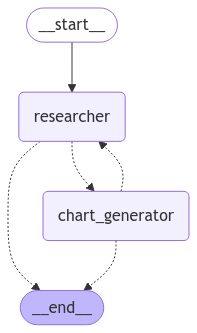

In [40]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Invoke

With the graph created, you can invoke it! Let's have it chart some stats for us.

Fetching pages: 100%|##########| 1/1 [00:00<00:00,  3.29it/s]


['URL:https://www.ons.gov.uk/economy/grossdomesticproductgdp/timeseries/ihyp/pn2 <document>[Document(metadata={\'source\': \'https://www.ons.gov.uk/economy/grossdomesticproductgdp/timeseries/ihyp/pn2\', \'title\': \'Gross Domestic Product: Year on Year growth: CVM SA % - Office for National Statistics\', \'language\': \'en\'}, page_content="### Tell us whether you accept cookies\\n\\nWe would like to use cookies to collect information about how you use\\n**ons.gov.uk**.\\n\\nWe use this information to make the website work as well as possible and\\nimprove our services.\\n\\nAccept all cookies\\n\\nSet cookie preferences\\n\\nYou’ve accepted all cookies. You can change your cookie settings at any time.\\nHide\\n\\nSkip to main content\\n\\n/economy/grossdomesticproductgdp/timeseries/ihyp/pn2\\n\\nEnglish (EN) |  Cymraeg (CY)\\n\\n  * Release calendar\\n  * Methodology\\n  * Media\\n  * About\\n  * Blog\\n\\n  * Menu\\n  * Search\\n\\n  * Home\\n  * Business, industry and trade \\n    *

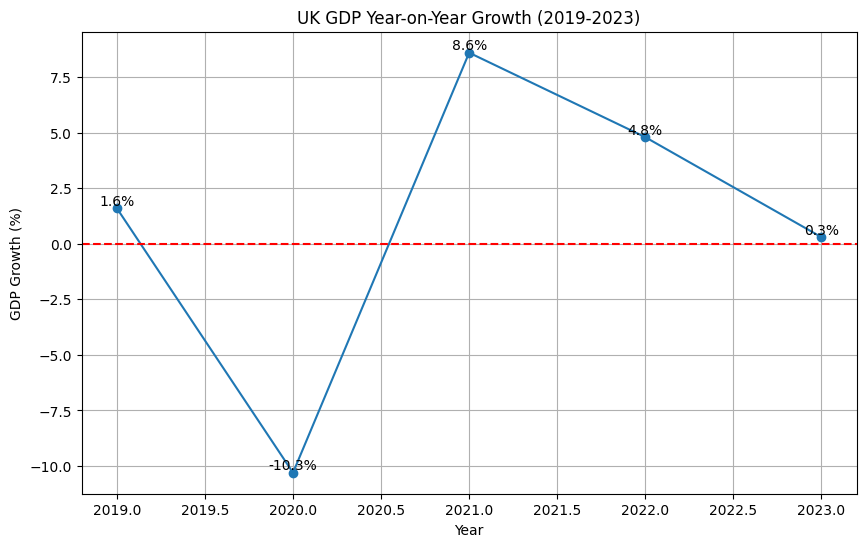

{'chart_generator': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart using python_repl tool, finish.", additional_kwargs={}, response_metadata={}, id='64bbf126-2a5a-4214-98bf-624289d6a2c4'), AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 507, 'completion_tokens': 118, 'total_tokens': 625}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'}, response_metadata={'usage': {'prompt_tokens': 507, 'completion_tokens': 118, 'total_tokens': 625}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'}, id='run-10b08930-b910-4e9d-87b9-00b1d154e90d-0', tool_calls=[{'name': 'search_web', 'args': {'search_query': 'UK GDP data past 5 years'}, 'id': 'toolu_bdrk_01VxNLCKU6zpRut4d4nPEvmi', 'type': 'tool_call'}], usage_metadata={'input_tokens': 507, 'output_tokens': 118, 'total_tokens': 625}), ToolMessage(content='{"context": ["URL:http

In [42]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the UK's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart using python_repl tool, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")